## Final Capstone Project

# The best restaurants to visit in Atlanta,USA

## Introduction 

This project helps to search venues in Atlanta, USA based upon their rating and average prices. In this notebook, we will explore various venues in the city of Atlanta, USA ibn order to help visitors select the restaurants as per their choice. We have used below APIs:
- Foursquare API and 
- Zomato API

Whenever a tourist is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

## Data Collection from APIs 

Atlanta is a capital of Georgia and is the biggest city in Southern part of America. This city is an attraction from various nationalities and hence, provides very good options of eateris for each culture.

Let's take a look at Atlanta on the Map using the folium library.

- Foursquare API: We will use the Foursquare API to fetch venues in Atlanta starting from the middle upto 5 Kilometers in each direction.
- Zomato API: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.



In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


Let's use the folium library to create a complete map zoomed on Atlanta. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

In [3]:
ATL_LATITUDE = '33.7490'
ATL_LONGITUDE = '-84.3894'
print('The LATITUDE and LONGITUDE of ATLANTA are {}, {}.'.format(ATL_LATITUDE, ATL_LONGITUDE))

The LATITUDE and LONGITUDE of ATLANTA are 33.7490, -84.3894.


In [4]:
!pip install folium
import folium

     |████████████████████████████████| 92kB 3.7MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/1d/e7/fd8b501e7a6dfe492a433deb7b9d833d39ca74916fa8bc63dd1a4947a671/Jinja2-2.10.1-py2.py3-none-any.whl
  Found existing installation: Jinja2 2.8
    Uninstalling Jinja2-2.8:
      Successfully uninstalled Jinja2-2.8
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
ATL_map = folium.Map(location = [ATL_LATITUDE, ATL_LONGITUDE], zoom_start = 13)
folium.Marker([ATL_LATITUDE, ATL_LONGITUDE]).add_to(ATL_map)
ATL_map.save("atlanta.html")
ATL_map

 __Foursquare API:__
 
We begin by fetching a total of all venues in Atlanta upto a range of 5 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [6]:
FOURSQUARE_CLIENT_ID = 'HZWPEN3VMCAE5LL15ORB2YYEZORAQGUZYBHMHT01HQE4YIWV'
FOURSQUARE_CLIENT_SECRET = '3O32KUWRSP5KGQYQPLGLJXYIA31RYTZFBB2GGROS3PCD2EPA'
RADIUS = 5000 # 5 Km
NO_OF_VENUES = 100
VERSION = '20190616' # Current date

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
We will set the radius as 5 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests


In [10]:

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        ATL_LATITUDE, 
                                                                        ATL_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 5.0 Km
Total 100 venues fetched within a total radius of 5.0 Km
Total 33 venues fetched within a total radius of 5.0 Km

Total 233 venues fetched


__Zomato API:__

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

The query will be the name of the venue.
The start defines from what offset we want to start, so we'll keep it at 0.
The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
We will supply the latitude and longitude values.
We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [11]:
headers = {'user-key': '16d896f78f9c8b0a4697d232ceb87914'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(7))



Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning 

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [12]:
vi =np.array(venues_information)
df= pd.DataFrame(vi,  columns = ['Venue', 'latitude','longitude', 'price_for_two','price_range', 'rating', 'address'])
df


,Venue,latitude,longitude,price_for_two,price_range,rating,address
0,Fish Bowl Poke,33.7540300000,-84.3798600000,0,1,0,"209 Edgewood Avenue, Downtown, Atlanta"
1,Escobar Restaurant And Tapas,33.7458830000,-84.4038540000,25,2,0,327 Peters Street Sw 30313
2,Nick's Food To Go,33.7476190000,-84.3797760000,15,1,4.2,"240 Martin Luther King Jr Drive SE, Atlanta 30312"
3,Blossom Tree,33.7555000000,-84.3891020000,20,2,3.9,"64 Peachtree Street, Downtown, Atlanta 30303"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Grindhouse Burgers,33.7540300000,-84.3798600000,15,1,4.4,"209 Edgewood Avenue SE, Suite 117/18 30303"
7,Aviva by Kameel,33.7601600000,-84.3870200000,25,2,4.2,225 Peachtree Street NE 30303
8,Meehan's Public House,33.7590292000,-84.3878560000,25,2,4.3,"200 Peachtree Street, Atlanta 30303"
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
ATL_map = folium.Map(location = [ATL_LATITUDE, ATL_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3188cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(ATL_map)  

ATL_map.save("Atlanta_Venues.html")
ATL_map

Let's plot the Zomato data on the map.

In [14]:
ATL_map = folium.Map(location = [ATL_LATITUDE, ATL_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(df['Venue'], df['address'], 
                                               df['latitude'], df['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(ATL_map)  

ATL_map.save("Atlanta Zomato .html")
ATL_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two APIs. However, there are others where the data does not match just like the red dots in the right on the second map.

To combine the two datasets, we'll have to check that the latitude and longitude values of each corresponding venue match. Thus, we will round both the latitude and longitude values upto 4 decimal places. Then,calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [15]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
df['latitude'] = df['latitude'].apply(lambda lat: round(float(lat), 4))
df['longitude'] = df['longitude'].apply(lambda lng: round(float(lng), 4))

In [16]:
dataset = pd.concat([foursquare_venues, df], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [18]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,Venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Nick's Food To Go,Greek Restaurant,33.7475,-84.3797,Nick's Food To Go,33.7476,-84.3798,15,1,4.2,"240 Martin Luther King Jr Drive SE, Atlanta 30312",0.0001,-0.0001
1,Blossom Tree,Korean Restaurant,33.7555,-84.3890,Blossom Tree,33.7555,-84.3891,20,2,3.9,"64 Peachtree Street, Downtown, Atlanta 30303",0.0000,-0.0001
2,Grindhouse Killer Burgers,Burger Joint,33.7542,-84.3799,Grindhouse Burgers,33.7540,-84.3799,15,1,4.4,"209 Edgewood Avenue SE, Suite 117/18 30303",-0.0002,0.0000
3,Sweet Auburn Curb Market,Farmers Market,33.7542,-84.3800,Miss D's New Orleans Style Candy,33.7543,-84.3799,25,2,3.4,"209 Edgewood Avenue SE, Atlanta 30303",0.0001,0.0001
4,Arepa Mia,Arepa Restaurant,33.7542,-84.3799,Arepa Mia,33.7541,-84.3800,10,1,4.0,"209 Edgewood Avenue SE, Downtown, Atlanta 30303",-0.0001,-0.0001
5,Alma Cocina,Latin American Restaurant,33.7591,-84.3875,Alma Cocina,33.7589,-84.3872,40,3,4.2,"191 Peachtree Street NE, Downtown 30303",-0.0002,0.0003
6,Red Phone Booth,Bar,33.7596,-84.3869,Red Phone Booth,33.7596,-84.3869,0,1,0,17 Andrew Young International Boulevard Northe...,0.0000,0.0000
7,Ria's Bluebird,Breakfast Spot,33.7466,-84.3735,Ria's Bluebird,33.7465,-84.3737,30,3,4.6,"421 Memorial Drive SE, Grant Park 30312",-0.0001,-0.0002
8,Atlanta Marriott Marquis,Hotel,33.7615,-84.3852,Sear,33.7616,-84.3851,70,4,3.4,265 Peachtree Center Avenue 30303,0.0001,0.0001
9,Six Feet Under Pub & Fish House,Seafood Restaurant,33.7466,-84.3729,Six Feet Under Pub & Fish House- Grant Park,33.7462,-84.3730,50,4,4.8,"437 Memorial Drive SE, Grant Park 30312",-0.0004,-0.0001


1. As we can see in a dataframe, lot of restaurants aren't mentioned with their __Rating__ and __Pricing__ ('price_for_two'). Hence, we will remove those restaurants from the datframe.
2. As we have combined data from both Foursquare and Zomato API, multiple colums are duplicating. Hence, we will remove them too.

In [30]:
col_to_drop= ['name', 'lat', 'lng', 'lat_diff', 'lng_diff']
selected_venues = selected_venues[selected_venues.columns.drop(col_to_drop)]


In [31]:
selected_venues = selected_venues[selected_venues['rating'] != "0"]
print("Total venues available: {}".format(selected_venues.shape[0]))
selected_venues

Total venues available: 86


,categories,Venue,latitude,longitude,price_for_two,price_range,rating,address
0,Greek Restaurant,Nick's Food To Go,33.7476,-84.3798,15,1,4.2,"240 Martin Luther King Jr Drive SE, Atlanta 30312"
1,Korean Restaurant,Blossom Tree,33.7555,-84.3891,20,2,3.9,"64 Peachtree Street, Downtown, Atlanta 30303"
2,Burger Joint,Grindhouse Burgers,33.7540,-84.3799,15,1,4.4,"209 Edgewood Avenue SE, Suite 117/18 30303"
3,Farmers Market,Miss D's New Orleans Style Candy,33.7543,-84.3799,25,2,3.4,"209 Edgewood Avenue SE, Atlanta 30303"
4,Arepa Restaurant,Arepa Mia,33.7541,-84.3800,10,1,4.0,"209 Edgewood Avenue SE, Downtown, Atlanta 30303"
5,Latin American Restaurant,Alma Cocina,33.7589,-84.3872,40,3,4.2,"191 Peachtree Street NE, Downtown 30303"
7,Breakfast Spot,Ria's Bluebird,33.7465,-84.3737,30,3,4.6,"421 Memorial Drive SE, Grant Park 30312"
8,Hotel,Sear,33.7616,-84.3851,70,4,3.4,265 Peachtree Center Avenue 30303
9,Seafood Restaurant,Six Feet Under Pub & Fish House- Grant Park,33.7462,-84.3730,50,4,4.8,"437 Memorial Drive SE, Grant Park 30312"
10,Coffee Shop,Octane Coffee / Little Tart Bakeshop,33.7461,-84.3730,10,1,4.3,"437 Memorial Drive, Atlanta 30312"


In [32]:
selected_venues = selected_venues[selected_venues['price_for_two'] != "0"]
print("Total venues available: {}".format(selected_venues.shape[0]))
selected_venues

Total venues available: 86


,categories,Venue,latitude,longitude,price_for_two,price_range,rating,address
0,Greek Restaurant,Nick's Food To Go,33.7476,-84.3798,15,1,4.2,"240 Martin Luther King Jr Drive SE, Atlanta 30312"
1,Korean Restaurant,Blossom Tree,33.7555,-84.3891,20,2,3.9,"64 Peachtree Street, Downtown, Atlanta 30303"
2,Burger Joint,Grindhouse Burgers,33.7540,-84.3799,15,1,4.4,"209 Edgewood Avenue SE, Suite 117/18 30303"
3,Farmers Market,Miss D's New Orleans Style Candy,33.7543,-84.3799,25,2,3.4,"209 Edgewood Avenue SE, Atlanta 30303"
4,Arepa Restaurant,Arepa Mia,33.7541,-84.3800,10,1,4.0,"209 Edgewood Avenue SE, Downtown, Atlanta 30303"
5,Latin American Restaurant,Alma Cocina,33.7589,-84.3872,40,3,4.2,"191 Peachtree Street NE, Downtown 30303"
7,Breakfast Spot,Ria's Bluebird,33.7465,-84.3737,30,3,4.6,"421 Memorial Drive SE, Grant Park 30312"
8,Hotel,Sear,33.7616,-84.3851,70,4,3.4,265 Peachtree Center Avenue 30303
9,Seafood Restaurant,Six Feet Under Pub & Fish House- Grant Park,33.7462,-84.3730,50,4,4.8,"437 Memorial Drive SE, Grant Park 30312"
10,Coffee Shop,Octane Coffee / Little Tart Bakeshop,33.7461,-84.3730,10,1,4.3,"437 Memorial Drive, Atlanta 30312"


Total venues available are 86 for Data Analysis.

## Methodology 

This project aims at identifying the venues in Atlanta, based upon their rating and price_for_two. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

- Step I: , we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Atlanta upto  5 Km radius. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

- Step II: Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

- Step III: We'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. 
We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis 

The complete dataset is now in its final form.

### Venues
We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

Categories
We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<Container object of 45 artists>

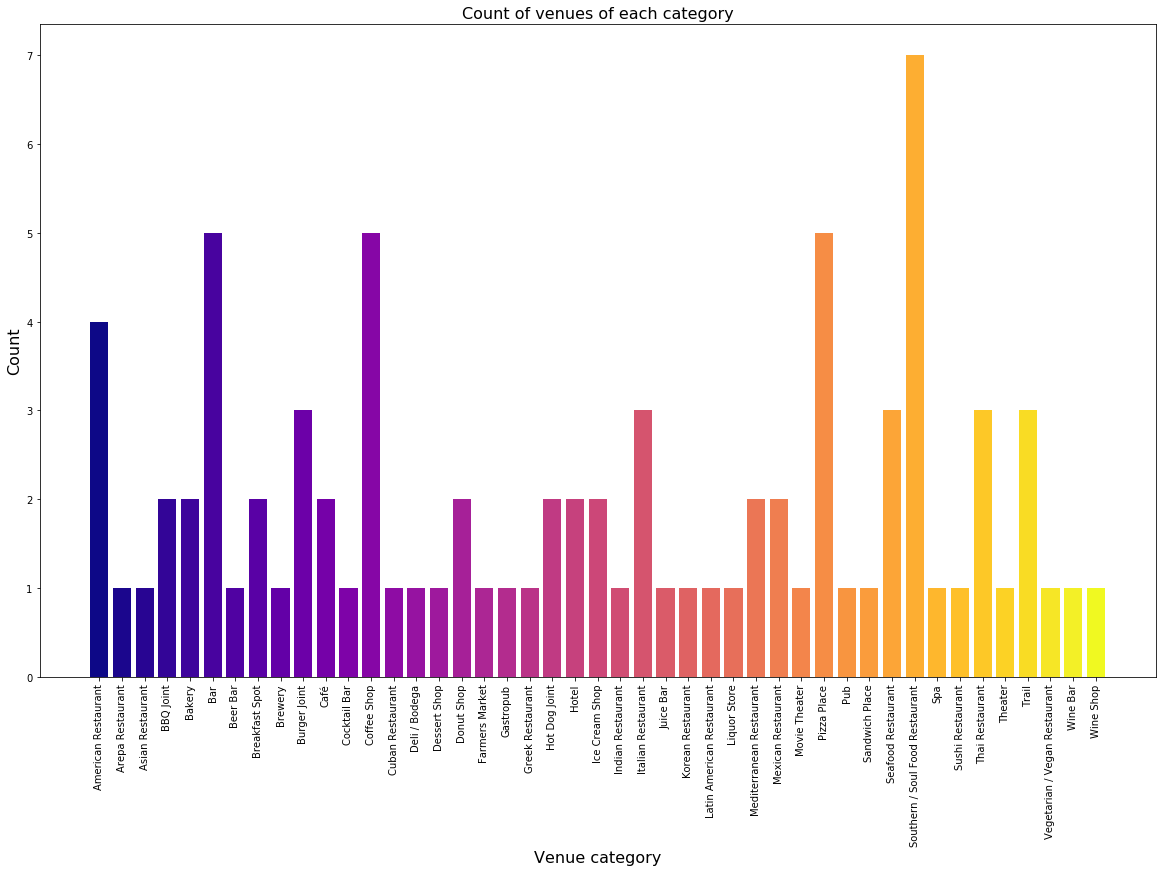

In [33]:
venue_distribution = selected_venues['categories'].value_counts().sort_index()
colors = cm.plasma(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are __Southern Food, coffee shops and Pizza place__. 



### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is price_for_two which defines the cost for two people and the other is price_range which determines the price range as defined by Zomato.

We will first explore the price_for_two using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5,1,'Count of venues with given average price')

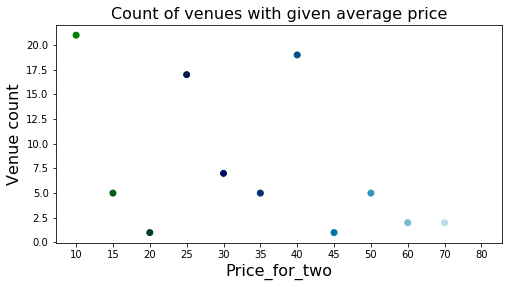

In [34]:
Prices = selected_venues['price_for_two'].value_counts().sort_index()
plt.figure(figsize = (8,4))
plt.scatter(Prices.index, 
            Prices.values,  
            c = cm.ocean(np.linspace(0, 1, len(Prices.index))))
plt.xlabel("Price_for_two", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5,1,'Count of venues with given rating')

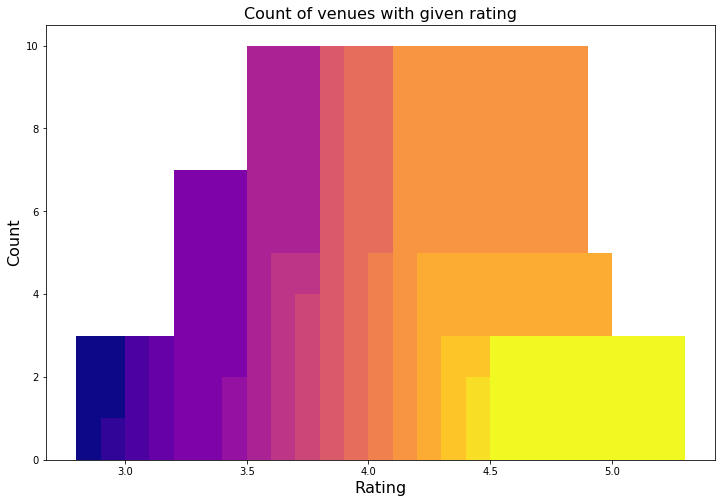

In [38]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (12, 8))
plt.bar(rating.index, rating.values, color = cm.plasma(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating between 3.5 to 4.5.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

3.0 to 3.5 <br>
3.5 to 4.0 <br>
4.0 to 4.5 <br>
4.5 to 5.0

In [41]:
bins = [3.0, 3.5, 4.0, 4.5, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)


In [42]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

ATL_map = folium.Map(location = [ATL_LATITUDE, ATL_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['Venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(ATL_map)  
ATL_map.save("Ratings.html")
ATL_map

The map has the location of all the venues. It appears that many venues are located near about NorthEast and NorthWest Avenue with rating above 4. 


## Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.


In [66]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = selected_venues.drop(['Venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues

ValueError: cannot insert cluster_labels, already exists

cluster_labels       int32
categories          object
Venue               object
latitude           float64
longitude          float64
price_for_two       object
price_range         object
rating             float64
address             object
rating_bin        category
dtype: object

In [78]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(20).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,Venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin
0,0,Farmers Market,Miss D's New Orleans Style Candy,33.7543,-84.3799,25,2,3.4,"209 Edgewood Avenue SE, Atlanta 30303",Low
1,0,Latin American Restaurant,Alma Cocina,33.7589,-84.3872,40,3,4.2,"191 Peachtree Street NE, Downtown 30303",Good
2,0,Breakfast Spot,Ria's Bluebird,33.7465,-84.3737,30,3,4.6,"421 Memorial Drive SE, Grant Park 30312",Very good
3,0,Cocktail Bar,The Sound Table,33.7541,-84.3718,25,2,3.9,"483 Edgewood Avenue SE, Old Fourth Ward, Atlan...",Okay
4,0,Mexican Restaurant,Agave Restaurant,33.7478,-84.3679,40,3,4.5,242 Boulevard SE 30312,Good
5,0,Pizza Place,Ammazza,33.7541,-84.3681,40,3,4.0,"591 Edgewood Avenue SE, Old Fourth Ward, Atlan...",Okay
6,0,Thai Restaurant,Poor Calvin's,33.7684,-84.3823,35,3,4.1,510 Piedmont Avenue. NE 30308,Good
7,0,Vegetarian / Vegan Restaurant,Herban Fix - Vegan Kitchen,33.7700,-84.3850,30,3,3.2,565 Peachtree St NE 30308,Low
8,0,Southern / Soul Food Restaurant,Busy Bee Cafe,33.7544,-84.4140,30,3,4.3,"810 Martin Luther King Junior Drive NW, 30314",Good
9,0,Bakery,Highland Bakery,33.7610,-84.3657,25,2,4.6,655 Highland Avenue NE 30312,Very good


In [72]:
result[["price_for_two", "price_range"]] = result[["price_for_two", "price_range"]].apply(pd.to_numeric)
print("These venues for cluster 0 have mean price range meal of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range meal of 4.00 and rating spread around 4.23


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [68]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,Venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin
0,1,Hotel,Sear,33.7616,-84.3851,70,4,3.4,265 Peachtree Center Avenue 30303,Low
1,1,Seafood Restaurant,Six Feet Under Pub & Fish House- Grant Park,33.7462,-84.3730,50,4,4.8,"437 Memorial Drive SE, Grant Park 30312",Very good
2,1,Italian Restaurant,BoccaLupo,33.7547,-84.3627,60,4,4.1,"753 Edgewood Avenue NE, Inman Park, Atlanta 30307",Good
3,1,Italian Restaurant,Sotto Sotto,33.7630,-84.3577,80,4,4.4,"313 N Highland Avenue NE, Inman Park, Atlanta ...",Good
4,1,Spa,Cafe Intermezzo,33.7834,-84.3832,50,4,4.5,"1065 Peachtree Street NE, Atlanta 30309",Good
5,1,Seafood Restaurant,The Optimist,33.7799,-84.4108,70,4,4.5,"914 Howell Mill Road, Westside 30318",Good
6,1,Hotel,Cafe Intermezzo,33.7834,-84.3832,50,4,4.5,"1065 Peachtree Street NE, Atlanta 30309",Good
7,1,Café,Cafe Intermezzo,33.7834,-84.3832,50,4,4.5,"1065 Peachtree Street NE, Atlanta 30309",Good
8,1,Sushi Restaurant,Eight Sushi Lounge,33.7800,-84.4118,50,4,3.3,"930 Howell Mill Road NW, Suite B 30318",Low
9,1,Thai Restaurant,Nan Thai Fine Dining,33.7915,-84.3897,60,4,4.3,"1350 Spring Street NW, Midtown, Atlanta 30309",Good


In [69]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 4.23


In [77]:
result = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(20).reset_index(drop = True)

Cluster 2


,cluster_labels,categories,Venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin
0,2,Greek Restaurant,Nick's Food To Go,33.7476,-84.3798,15,1,4.2,"240 Martin Luther King Jr Drive SE, Atlanta 30312",Good
1,2,Korean Restaurant,Blossom Tree,33.7555,-84.3891,20,2,3.9,"64 Peachtree Street, Downtown, Atlanta 30303",Okay
2,2,Burger Joint,Grindhouse Burgers,33.7540,-84.3799,15,1,4.4,"209 Edgewood Avenue SE, Suite 117/18 30303",Good
3,2,Arepa Restaurant,Arepa Mia,33.7541,-84.3800,10,1,4.0,"209 Edgewood Avenue SE, Downtown, Atlanta 30303",Okay
4,2,Coffee Shop,Octane Coffee / Little Tart Bakeshop,33.7461,-84.3730,10,1,4.3,"437 Memorial Drive, Atlanta 30312",Good
5,2,American Restaurant,Atlanta Breakfast Club,33.7647,-84.3955,10,1,3.9,"249 Ivan Allen Junior Boulevard, Atlanta 30313",Okay
6,2,Café,LottaFrutta,33.7560,-84.3681,10,1,4.1,"590 Auburn Avenue NE, Atlanta 30312",Good
7,2,Trail,Hilda's,33.7578,-84.3652,10,1,3.2,"660 Irwin Street, Atlanta 30312",Low
8,2,Theater,The New American Shakespeare Tavern,33.7682,-84.3849,10,1,3.5,"499 Peachtree Street, Atlanta 30308",Low
9,2,Dessert Shop,Julianna's Coffee & Crepes,33.7581,-84.3621,15,1,3.6,"775 Lake Avenue NE, Atlanta 30307",Okay


In [74]:
print("These venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 2 have mean price range of 1.04 and rating spread around 3.97


## Results and Discussion 

After collecting data from the Foursquare and Zomato APIs, we collected data for of 233 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of __86__.

We identified that from the total set of venues, majority of them were Southern restaurants, Coffee shops and Pizza centers. 

When we take a look at the price values of each venue, we explore that many venues have __prices__ which are offering meal at USD 10,  USD 40 and  USD 25 for two people. However, the variation in prices is very large, given the complete range starts from  USD 10 and goes uptil  USD 70. 

While the complete range of ratings range from 1 to 5, the majority venues have __ratings__ was between 3.5 to 4.5. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around Northeastern and Northwestern Avenue near Georgia University. These clusters also have very high ratings (more than 3.9).


Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.97. On the other hand, there are few venues which are high priced and have average rating of 4.23.

If you're looking for __low priced places with relatively high rating__, you should check Peachtree Street .
If you're looking for the best places, with the __highest rating but might also carry a high price tag__, you should visit downtown restaurants near Highland Avenue.
If you're looking to explore the city and have __intermediate requirements on budget and rating__ to decide upon the places you want to visit, you should try Spring street.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion

The purpose of this project was to explore the places that a person visiting Atlanta can go for a meal. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Peachtree Street, Highland Avenue or Spring street . Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.